In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import src.preprocessing as prepro
import src.data_handler as data_handler
from src.models import LinealReg

raw_data : data_handler.RawData = data_handler.RawData()

In [2]:
engineered_data : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=True, standarize=False, area_units='m2')
engineered_data.fill_missing_values(method='mean')
engineered_data.casas_dev['high_latitude'] = np.where(engineered_data.casas_dev['lat'] > 0, True, False)
engineered_data.casas_dev = engineered_data.casas_dev.drop(columns=['lon', 'lat', 'area_units'])
engineered_data.casas_dev.head()

,area,is_house,has_pool,age,price,rooms,high_latitude
0,59,True,False,18,546,2,True
1,102,False,False,9,759,3,True
2,62,False,False,7,464,2,True
3,127,True,True,16,251,4,False
4,128,False,False,8,963,4,True


In [3]:
train : pd.DataFrame
validation : pd.DataFrame
train, validation = data_handler.get_train_and_validation_sets(engineered_data.casas_dev, train_fraction=0.8, seed=42)
train_standarized : pd.DataFrame = prepro.standarize_numeric_columns(train, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
validation_standarized : pd.DataFrame = prepro.standarize_numeric_columns(train, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
other_features = ['area', 'price', 'age', 'rooms', 'high_latitude']
train_means : dict[str, float] = {f : train[f].mean() for f in other_features}
train_stds : dict[str, float] = {f : train[f].std() for f in other_features}
validation_means : dict[str, float] = {f : validation[f].mean() for f in other_features}
validation_stds : dict[str, float] = {f : validation[f].std() for f in other_features}

5.2 )

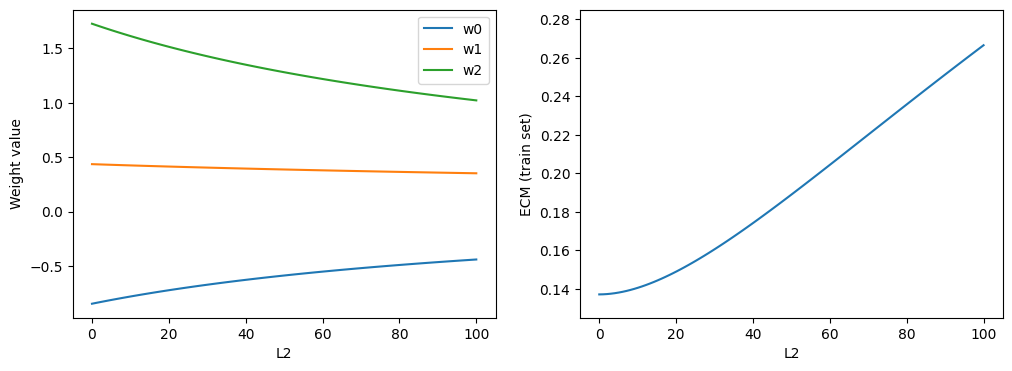

In [4]:
L2s : list[float] = np.linspace(0, 100, 100)
ECM2s : list[float] = []
coefsL2 : list[tuple[float, float, float]] = []
for l in L2s: 
    lin : LinealReg = LinealReg(train_standarized[['area', 'high_latitude']].to_numpy(), train_standarized['price'].to_numpy(), L2=l)
    lin.fit_gradient_descent(step_size=0.00005, tolerance=0.5, max_number_of_steps=-1)
    coefsL2.append(lin.coef)
    # ECM2s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized, validation_set_y=validation_standarized['price'].to_numpy()))
    ECM2s.append(lin.error_cuadratico_medio())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL2).shape[1]):
    plt.plot(L2s, np.array(coefsL2)[:, i], label=f'w{i}')
plt.xlabel('L2')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L2s : list[float] = np.linspace(0, 100, 100)
plt.xlabel('L2')
plt.ylabel('ECM (train set)')
plt.ylim(0.125, 0.285)
plt.plot(L2s, ECM2s)
plt.show()

5.3 )

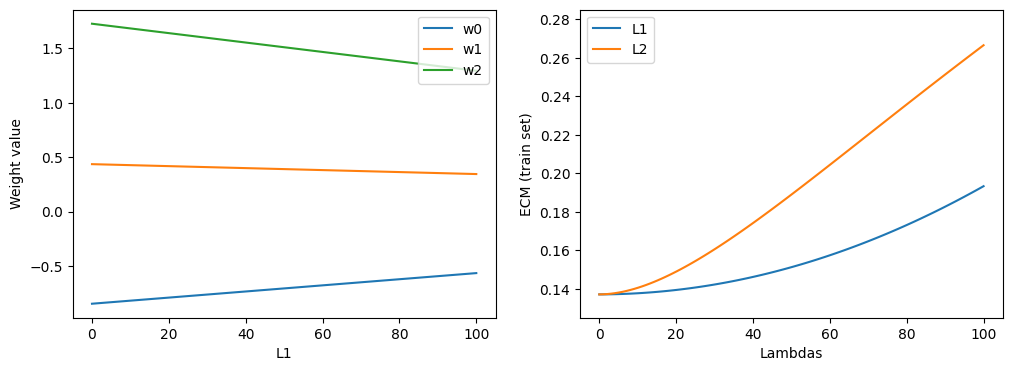

In [ ]:
L1s : list[float] = np.linspace(0, 100, 100)
ECM1s : list[float] = []
coefsL1 : list[tuple[float, float, float]] = []
for l in L1s: 
    lin : LinealReg = LinealReg(train_standarized[['area', 'high_latitude']].to_numpy(), train_standarized['price'].to_numpy(), L1=l)
    lin.fit_gradient_descent(step_size=0.00005, tolerance=0.5, max_number_of_steps=-1)
    coefsL1.append(lin.coef)
    # ECM1s.append(lin.error_cuadratico_medio(validation_set=validation_standarized['price'].to_numpy()))
    ECM1s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized.to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL1).shape[1]):
    plt.plot(L1s, np.array(coefsL1)[:, i], label=f'w{i}')
plt.xlabel('L1')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L1s : list[float] = np.linspace(0, 100, 100)
plt.xlabel('Lambdas')
plt.ylabel('ECM (train set)')
plt.ylim(0.125, 0.285)
plt.plot(L1s, ECM1s, label='L1')
plt.plot(L2s, ECM2s, label='L2')
plt.legend()
plt.show()

5.4 ) En 5.3, vimos que el error cuadrático medio evaluado de los lambdas en el set de validation, aumenta más rápidamente en el caso de L2 que L1. En ambos casos no se nota una mejora en el modelo.